# Pliable Lasso in Python

This will all use the same example found in the pliable lasso paper.

In [1]:
import numpy as np
import numpy.linalg as la
import cvxpy as cvx

import matplotlib.pyplot as graph
import seaborn as sns

from scipy import stats
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


def v2a(a):
    return a.reshape((len(a), 1))


graph.style.use('fivethirtyeight')
print(cvx.__version__)  # Make sure it's 1.0.11 or greater

1.0.11


## First Classical Lasso

$ y = X \beta $

$ J(\beta, \lambda) = ||X \beta||_2^2 + \lambda||\beta||_1 $

In [2]:
# Fake data
n = 100
p = 50
k = 4

beta = np.zeros(p)
beta[:4] = [2, -2, 2, 2]
print(beta)

x = stats.norm().rvs(size=(n, p))
y = x @ beta
y += 0.5*stats.norm().rvs(n)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print(x.shape, y.shape)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

[ 2. -2.  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
(100, 50) (100,)
(80, 50) (20, 50) (80,) (20,)


In [3]:
def y_hat(x, beta):
    return x @ beta


def mse(x, y, beta):
    return (0.5 * x.shape[0]) * cvx.norm(y_hat(x, beta) - y, p=2) ** 2


def penalty(lam, beta):
    return lam * cvx.norm(beta, p=1)


def j(x, y, beta, lam):
    return mse(x, y, beta) + penalty(lam, beta)

In [4]:
# Setup
beta_hat = cvx.Variable(p)
lam = cvx.Parameter(nonneg=True)
problem = cvx.Problem(cvx.Minimize(
    j(x_train, y_train, beta_hat, lam)
))

In [5]:
%%time
lambdas = np.logspace(1, 5, 20)  # I know this is a list of large lambda values.

test_scores = []
beta_path = []
for lam_i in lambdas:
    lam.value = lam_i
    problem_result = problem.solve()
    
    test_scores.append(r2_score(y_test, x_test @ beta_hat.value))
    beta_path.append(beta_hat.value)
    
beta_path = np.vstack(beta_path)
print(beta_path.shape)

(20, 50)
CPU times: user 657 ms, sys: 4 ms, total: 661 ms
Wall time: 669 ms


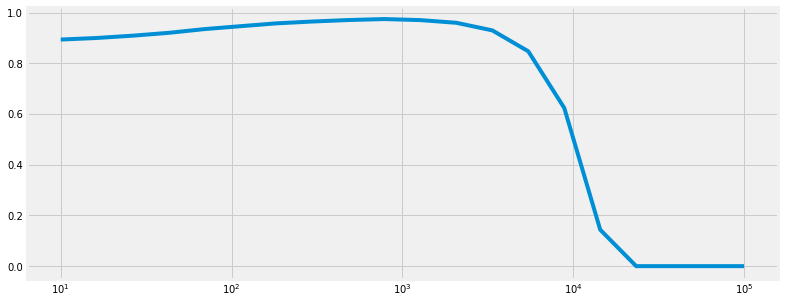

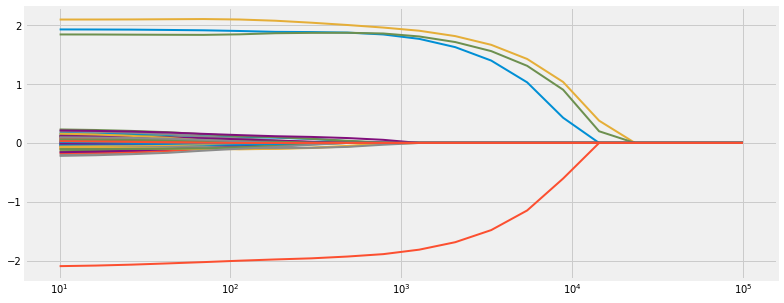

In [6]:
graph.figure(figsize=(12, 5))
graph.plot(lambdas, test_scores)
graph.xscale('log')
graph.show()

graph.figure(figsize=(12, 5))
for p_i in range(p):
    graph.plot(lambdas, beta_path[:, p_i], linewidth=2)
graph.xscale('log')
graph.show()

## Now the Pliable Lasso

$ y = \beta_0 1 + Z \theta_0 + \sum X_j(\beta_j 1 + Z \theta_j) $

$ J(\beta_0, \theta_0, \beta, \theta) = {{1}\over{2N}} \sum$

In [7]:
beta_0 = 0
theta_0 = np.zeros(k)

beta = np.zeros(p)
beta[:4] = [2, -2, 2, 2]

theta = np.zeros((p, k))
theta[2, 0] = 2.0
theta[3, 1] = -2.0

z = stats.bernoulli(p=0.5).rvs(size=(n, k))
print(z.shape)

y = x[:, 0] * beta[0]
y += x[:, 1] * beta[1]
y += x[:, 2] * (beta[2] + 2*z[:, 0])
y += x[:, 3] * (beta[3] - 2*z[:, 1])

y_gt = y.copy()
y += 0.5 * stats.norm().rvs(n)  # Add noise from paper

# Train test split
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

print(x.shape, y.shape)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, z_train.shape, z_test.shape)

(100, 4)
(100, 50) (100,)
(80, 50) (20, 50) (80,) (20,) (80, 4) (20, 4)


In [8]:
def check_properties(obj, name=''):
    print(name, f'DCP {obj.is_dcp()}', f'Convexity {obj.is_convex()}')

In [13]:
# Functions
def compute_w_j(x, z, j):
    k = z.shape[1]
    x_j = np.tile(v2a(x[:, j]), (1, k))
    return x_j * z


def y_hat(beta_0, theta_0, beta, theta, x, z):  # Confirmed DCP and Convex
    n = x.shape[0]
    p = x.shape[1]
    k = z.shape[1]
    
    intercepts = beta_0 + (z @ theta_0)
    
    shared_model = x @ beta
    
    pliables = np.zeros(n)
    for j_i in range(p):
        w_j = compute_w_j(x, z, j_i)
        pliables = pliables + (w_j @ theta[j_i, :])
        
    output = intercepts + shared_model + pliables
    return output


def j(beta_0, theta_0, beta, theta, x, y, z, alpha, lam):
    n, p = x.shape
    
    mse = (0.5*n) * cvx.sum((y - y_hat(beta_0, theta_0, beta, theta, x, z))**2)
    
    beta_matrix = cvx.reshape(beta, (p, 1))
    
    penalty_1 = cvx.sum(cvx.norm(cvx.hstack([beta_matrix, theta]), p=2, axis=1))
    penalty_2 = cvx.sum(cvx.norm(theta, p=2, axis=1))
    penalty_3 = cvx.sum(cvx.norm(theta, p=1))
    
#     loss = mse + (1-alpha) * lam * (penalty_1 + penalty_2) + alpha * lam * penalty_3
    loss = mse + lam * (penalty_1 + penalty_2) + lam * penalty_3
    check_properties(loss, 'loss')
    return loss

In [14]:
# Setup
# Parameters
beta_hat_0 = cvx.Variable(1)
theta_hat_0 = cvx.Variable(k)
beta_hat = cvx.Variable(p)
theta_hat = cvx.Variable((p, k))

print('beta_0', beta_hat_0.shape)
print('theta_0', theta_hat_0.shape)
print('beta', beta_hat.shape)
print('theta', theta_hat.shape)
print('='*20)

# Hyperparameters
alpha = cvx.Parameter(nonneg=True)
alpha.value = 0.5
lam = cvx.Parameter(nonneg=True)
lam.value = 10**(2)

# Solve
problem = cvx.Problem(
    cvx.Minimize(j(beta_hat_0, theta_hat_0, beta_hat, theta_hat, x_train, y_train, z_train, alpha, lam))
)

beta_0 (1,)
theta_0 (4,)
beta (50,)
theta (50, 4)
loss DCP False Convexity False


In [11]:
%%time
lambdas = np.logspace(1, 6, 30)

test_scores = []
beta_path = []
for lam_i in lambdas:
    lam.value = lam_i
    soln = problem.solve()
    
    test_scores.append(
        r2_score(
            y_test, 
            y_hat(beta_hat_0.value, theta_hat_0.value, beta_hat.value, theta_hat.value, x_test, z_test))
    )
    beta_path.append(beta_hat.value)
    
beta_path = np.vstack(beta_path)

CPU times: user 6.11 s, sys: 4.17 ms, total: 6.12 s
Wall time: 6.14 s


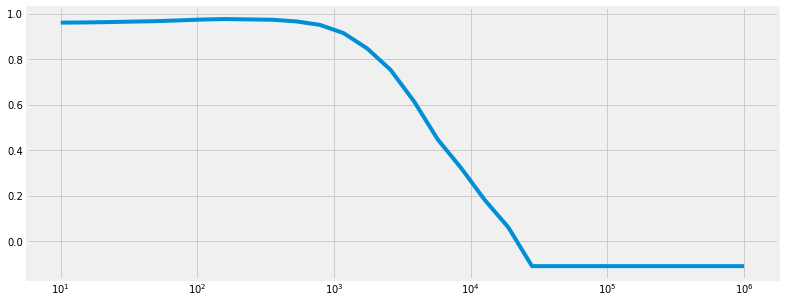

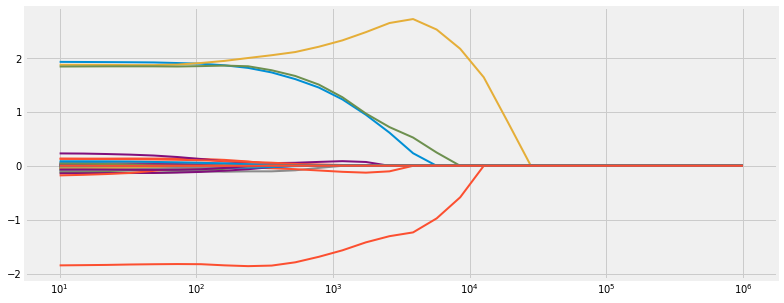

In [12]:
graph.figure(figsize=(12, 5))
graph.plot(lambdas, test_scores)
graph.xscale('log')
graph.show()

graph.figure(figsize=(12, 5))
for p_i in range(p):
    graph.plot(lambdas, beta_path[:, p_i], linewidth=2)
graph.xscale('log')
graph.show()